# Cliff Walking
---
Este problema es muy parecido al de windy grid, nomas que ahora hay una condicion de perder o como me gusta llamarle de morir, ahora nuestro agente quiere llegar de un lado de un precipicio al otro, y obviamente es un precipicio bastante cuadrado, donde los bloques que estan abajo son la caida al infinito, y se empieza de una esquina de abajo y termina en la otra esquina de abajo, pareceria que es bastante sencillo llegar al final pero sera necesario ver como nuestro agente en sarsa se desempena, y agregaremos nuevos metodos de aprendizaje por refuerzo.
Aqui es donde nos da gusto de que sean simulaciones y no personas de verdad intentando hacerlo, uno moriria en la primera equivocacion.

In [11]:
using PyPlot
ioff()

definimos el tamano de nuestro universo, acciones, inicio y final del recorrido, al mismo tiempo aqui definimos la probabilidad de exploracion/explotacion la cual habiamos mencionado antes, alpha que es el tamano que tiene un paso, y gamma que nos dira que tanto aprenden nuestros algoritmos cad aiteracion

In [2]:
# world height
WORLD_HEIGHT = 4

# world width
WORLD_WIDTH = 12

# probability for exploration
EPSILON = 0.5

# step size
ALPHA = 0.5

# gamma for Q-Learning and Expected Sarsa
GAMMA = 1

# all possible actions
ACTION_UP = 1
ACTION_DOWN = 2
ACTION_LEFT = 3
ACTION_RIGHT = 4
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# initial state action pair values
START = [4, 1]
GOAL = [4, 12];

# Paso
---
Los pasos son similares a los del windy grid, nomas que ahora si caemos en un lugar erroneo, pues volvemos al principio y nos da una recompensa de -100, cabe notar que a diferencia de anteriores funciones de paso ahora regresamos y calculamos la recompensa

In [3]:
function step(state, action)
    i, j = state
    if action == ACTION_UP
        next_state = [max(i - 1, 1), j]
    elseif action == ACTION_LEFT
        next_state = [i, max(j - 1, 1)]
    elseif action == ACTION_RIGHT
        next_state = [i, min(j + 1, WORLD_WIDTH)]
    elseif action == ACTION_DOWN
        next_state = [min(i + 1, WORLD_HEIGHT), j]
    else
        return false
    end
    
    reward = -1
    if (action == ACTION_DOWN && i == 3 && 2 <= j && j <= 11) ||
        (action == ACTION_RIGHT && state == START)
        reward = -100
        next_state = START
    end
    return next_state, reward
end

step

step (generic function with 1 method)

# Elegir accion
---
Aqui cambiamos un poco nuestros algoritmos pasados, ahora para facilidad de reciclaje de codigo la funcion choose_action nos eligira si vamos a explorar o explotar y a su vez elige una accion al azar o la mejor accion que conocemos en el momento para el estado donde estamos parado.

In [4]:
function choose_action(state, q_value)
    if rand(1)[1] < EPSILON
        return ACTIONS[rand(1:4)]
    else
        values_ = q_value[state[1], state[2],:]
        action = []
        for i in enumerate(values_)
            action_,value_ = i
            if value_ == maximum(values_)
                push!(action,action_)
            end
        end
        action = action[rand(1:length(action))]
        return action
    end
end

choose_action (generic function with 1 method)

# Sarsa
---
Ahora volvemos a implementar sarsa, se basa en lo mismo que he explicado en anteriores libretas, pero ahora esta generalizado para ser utilizado con universos cuadrados. Igual dado un estado, accion, recompensa, siguiente estado y siguiente accion, podemos calcular un nuevo valor para nuestra tabla q en nuestro estado actual, y iterar hasta llegar a nuestro objetivo

In [5]:
function sarsa(q_value, expected = false, step_size = ALPHA)
    state = START
    action = choose_action(state, q_value)
    rewards = 0.0
    while state != GOAL
        next_state, reward = step(state, action)
        next_action = choose_action(next_state,q_value)
        rewards += reward
        if !expected
            target = q_value[next_state[1], next_state[2], next_action]
        else
            target = 0.0
            q_next = q_value[next_state[1], next_state[2], :]
            best_actions = transpose(hcat(nonzero(q_next == np.max(q_next))...))
            for action_ in ACTIONS
                if action_ in best_actions
                    target += ((1.0 - EPSILON) / len(best_actions) + EPSILON / len(ACTIONS)) * q_value[next_state[1], next_state[2], action_]
                else
                    target += EPSILON / len(ACTIONS) * q_value[next_state[1], next_state[2], action_]
                end
            end
        end
        target = target * GAMMA
        q_value[state[1], state[2], action] += step_size * (reward + target - q_value[state[1], state[2], action])
        state = next_state
        action = next_action
    end
    return rewards
end            

sarsa (generic function with 3 methods)

# Q_learning
---
Nuevo concepto en estas libretas.
Q learning al igual que sarsa es un algoritmo de aprendizaje por refuerzo basado en procesos de decision markoviana, y este en lugar de utilizar el estado y accion actual y siguiente, crea un nuevo valor para q o el sigueinte  utilizando el valor anterior de q y una estimacion del valor de q que del siguiente estado que podra tomar en un futuro, tambien utilizando la accion con el reward mas grande. el codigo es mas compacto y facil de comprender. por este tipo de cosas podemos decir que Q_learning elige acciones por la calidad que puede llegar a tener en un estado dado.


In [6]:
function q_learning(q_value, step_size = ALPHA)
    state = START
    rewards = 0.0
    while state != GOAL
        action = choose_action(state, q_value)
        next_state, reward = step(state, action)
        rewards += reward
        # Q-Learning update
        q_value[state[1], state[2], action] += step_size * (
                reward + GAMMA * maximum(q_value[next_state[1], next_state[2], :]) -
                q_value[state[1], state[2], action])
        state = next_state
    end
    return rewards
end

q_learning (generic function with 2 methods)

In [30]:
function print_optimal_policy(q_value)
    optimal_policy = []
    for i in range(1, stop=WORLD_HEIGHT)
        push!(optimal_policy,[])
        for j in range(1, stop=WORLD_WIDTH)
            if [i, j] == GOAL
                append!(optimal_policy[end], 'G')
                continue
            end
            bestAction = argmax(q_value[i, j, :])
            if bestAction == ACTION_UP
                append!(optimal_policy[end], '↑')
            elseif bestAction == ACTION_DOWN
                append!(optimal_policy[end], '↓')
            elseif bestAction == ACTION_LEFT
                append!(optimal_policy[end], '←')
            elseif bestAction == ACTION_RIGHT
                append!(optimal_policy[end], '→')
            end
        end
    end
    for row in optimal_policy
        println(row)
    end
end

print_optimal_policy (generic function with 1 method)

# episodio
---
a diferencia de pasados trabajos aqui no definimos un episodio en una funcion si no que, como en si un episodio es una corrida de sarsa o q learning lo corremos iterativamente un numero n de veces, y por esto podemos correr concurrentemente ambos algoritmos definiendo distintas tablas para cada uno, utilizando los mismos paramentros en ambos y guardando sus recompensas en distintos lugares

In [39]:
episodes = 500
runs = 50
rewards_q_learning = zeros(episodes)
rewards_sarsa = zeros(episodes)
q_q_learning = []
q_sarsa = []
for r in 1:runs  
    q_q_learning = zeros(WORLD_HEIGHT, WORLD_WIDTH , 4)
    q_sarsa = zeros(WORLD_HEIGHT, WORLD_WIDTH, 4)
    for i in 1:episodes
        rewards_q_learning[i] += q_learning(q_q_learning)
        rewards_sarsa[i] += sarsa(q_sarsa)
    end
end

rewards_q_learning /= runs;
rewards_sarsa /= runs;


In [36]:
println("Q-Table inicial:")
print_optimal_policy(zeros(WORLD_HEIGHT, WORLD_WIDTH , 4))

Q-Table inicial:
Any['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑']
Any['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑']
Any['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑']
Any['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', 'G']


Podemos comparar las tablas resultantes rapidamente y encontraremos casid e forma inmediata ambos llegan a su objetivo, pero usando el camino de Q-learning notamos que el camino es mas corto, podriamos decir que de mayor calidad que el de sarsa, ya que este busca tener la mayor calidad para cada uno de sus acciones. podemos observar la linea que lleva hacia G es una linea recta y lo mas inmediat aposible a difernecia de sarsa que es una linea que camina por distintas regiones de nuestro mundo.
Si nosotros fueramos personas probablemente prefeririamos Sarsa, porque asi sabemos que podemos apreciar el barranco de desde distintos puntos de vista en lugar de utilizando el mismo camino.


In [40]:
println("Q-Learning Optimal Policy:")
print_optimal_policy(q_q_learning)
println("SARSA Optimal Policy:")
print_optimal_policy(q_sarsa)

Q-Learning Optimal Policy:
Any['↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓']
Any['↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓']
Any['→', '→', '→', '→', '→', '→', '→', '→', '→', '→', '→', '↓']
Any['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', 'G']
SARSA Optimal Policy:
Any['→', '→', '→', '↑', '→', '→', '→', '→', '→', '→', '→', '↓']
Any['↑', '↑', '↑', '↑', '↑', '→', '↑', '←', '→', '→', '→', '↓']
Any['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '→', '↓']
Any['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', 'G']


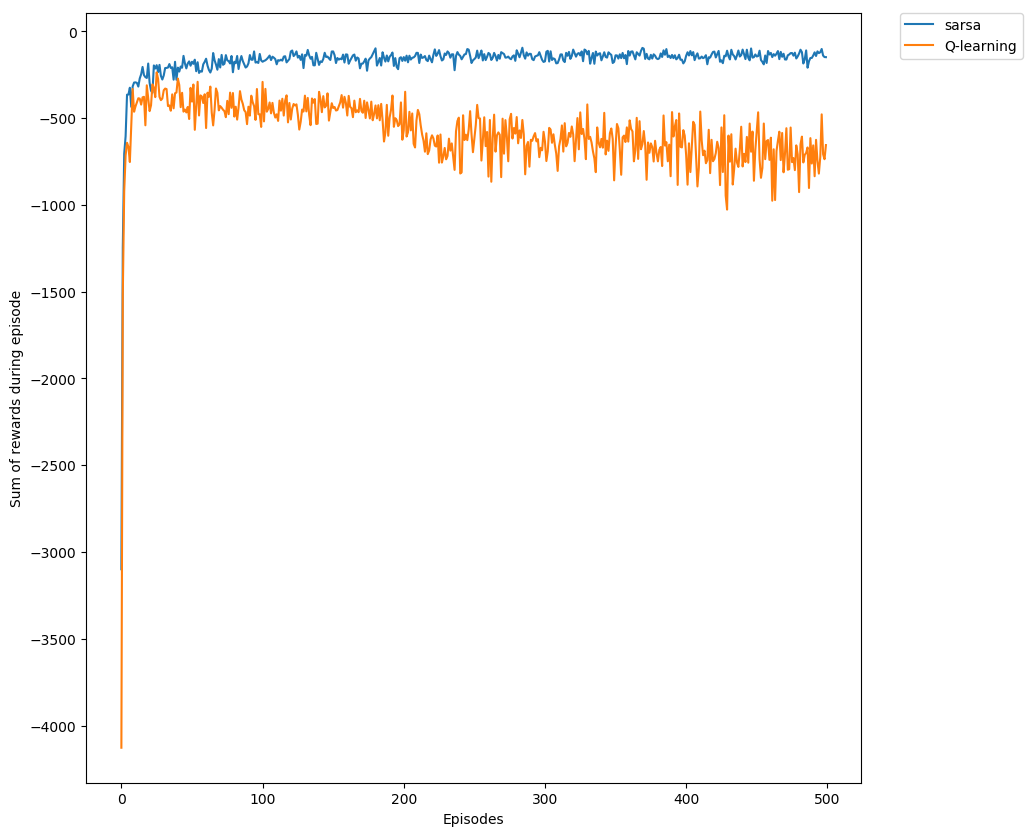

In [38]:
fig, ax = plt[:subplots](figsize=(10,10))
plt[:plot](rewards_sarsa, label = "sarsa")
plt[:plot](rewards_q_learning, label = "Q-learning")
plt[:legend](bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt[:xlabel]("Episodes")
plt[:ylabel]("Sum of rewards during episode");

Finalmente en esta comparacion entre sarsa y q- learning podemos ver que rapidamente ambos encuentran un camino bueno pero q-learning encuentra el camino optimo de esto, osease tarda menos en caminar y por lo mismo su recompensa es menor que la de sarsa en la gran mayoria del tiempo